# Práctica guiada

## Predicción de enfermedad cardíaca con Random Forest

<img src="img/heart-health-tips-animation-thumbnail.gif" alt="hearth">


El hospital de León quiere **predecir riesgo de enfermedad cardíaca** a partir de datos clínicos básicos de pacientes.


El objetivo **no es solo entrenar un modelo**, sino **decidir qué modelo es más adecuado**, cómo configurarlo y **explicar por qué**.

Trabajarás con:

* `heart.csv` → dataset completo
* `heart_disease_4features.csv` → versión reducida y más interpretable

El cuaderno base utiliza **Random Forest**, búsqueda de hiperparámetros y visualización de árboles .

---

## Resultados de aprendizaje trabajados

* **RA2.c** Define el modelo a implementar
* **RA2.d** Implementa la aplicación
* **RA2.e** Evalúa resultados

---

## Entrega

Un **notebook Jupyter** en formato PDF con:

* Código funcional
* Respuestas razonadas en Markdown
* Gráficas y métricas
* Conclusiones claras

---

## ¿Qué es Random Forest?

**Random Forest** es un algoritmo de **aprendizaje automático supervisado** que se utiliza tanto para **clasificación** como para **regresión**.

La idea principal es sencilla:

> En lugar de tomar una decisión con un solo árbol de decisión, Random Forest entrena **muchos árboles distintos** y combina sus resultados para obtener una predicción más fiable.

---

## ¿Cómo funciona?

1. Se crean **muchos subconjuntos distintos** del conjunto de entrenamiento (muestreo con reemplazo).
2. Con cada subconjunto se entrena **un árbol de decisión diferente**.
3. En cada árbol, las divisiones se hacen usando **solo una parte aleatoria de las variables**.
4. Para clasificar un nuevo dato:

   * Cada árbol da su predicción.
   * El modelo final decide por **votación mayoritaria**.

Este proceso reduce los errores debidos a:

* árboles demasiado complejos
* datos ruidosos
* sobreajuste al conjunto de entrenamiento

<img src="img/random-forest.png" alt="random forest">

---

## ¿Por qué no usar un solo árbol de decisión?

Un árbol de decisión:

* es fácil de entender
* pero **muy sensible a los datos**
* puede memorizar el entrenamiento (overfitting)

Random Forest soluciona esto porque:

* combina muchos árboles simples
* promedia sus decisiones
* generaliza mejor a datos nuevos

---

## Ventajas de Random Forest

* Funciona bien con **datos tabulares**
* No necesita normalización de variables
* Captura relaciones **no lineales**
* Es robusto frente al ruido
* Permite estimar la **importancia de las variables**

Por eso es muy utilizado en:

* medicina
* banca
* detección de fraude
* problemas reales con datos estructurados

---

## Inconvenientes

* Es menos interpretable que un solo árbol
* Consume más tiempo y recursos
* No es ideal cuando se necesita un modelo muy simple o explicable al 100%

Más información

[Machine Learning Google](https://developers.google.com/machine-learning/decision-forests?hl=es-419)

[Videotutorial: Random Forests con Python](https://www.youtube.com/watch?v=VfMPslt2wgA)

---

In [24]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score
)

## Parte 1 – Exploración y comprensión del dataset (obligatoria)

### 1.1 Carga de datos

Carga ambos datasets y responde:

In [25]:
df_heart = pd.read_csv("./data/heart.csv")
df_4_features = pd.read_csv("./data/heart_disease_4features.csv")

In [26]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [27]:
df_4_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  1025 non-null   int64
 1   age         1025 non-null   int64
 2   sex         1025 non-null   int64
 3   trestbps    1025 non-null   int64
 4   chol        1025 non-null   int64
 5   target      1025 non-null   int64
dtypes: int64(6)
memory usage: 48.2 KB


<div style="background-color:green;color:white">

<br>

**Cuestiones (responde en Markdown):**

* ¿Cuántas variables tiene cada dataset?

    - El dataset heart tiene 14 características
    - El dataset heart_disease_4features tiene 6 características 

* ¿Cuál crees que será más fácil de explicar a un médico?

    - Será más facil para explicar el que tenga menos variables ya que no tiene tantos condicionantes para la predicción

* ¿Qué se pierde al reducir variables?

    - Se pierden valor de datos que no estamos usando


<br>

---

### 1.2 Variable objetivo

<div style="background-color:green;color:white">

<br>

* Identifica claramente la variable *objetivo*

    - La variable Objetivo es target

* Explica qué significa *0* y *1*

    - 0 es que no tiene enfermedad cardiovascular
    - 1 es que tiene enfermedad cardiovascular
* Comprueba si hay **desbalanceo de clases**

    - No hay balanceo de clases en los datasets

 <br>

In [28]:
print('heart',df_heart["target"].value_counts())
print("4features",df_4_features["target"].value_counts())

heart target
1    526
0    499
Name: count, dtype: int64
4features target
1    526
0    499
Name: count, dtype: int64


## Parte 2 – Primer modelo Random Forest (baseline)

### 2.1 Separación train/test

Usa `train_test_split` con:

* `test_size=0.2`
* `random_state=42`



In [29]:
df_4_features.columns

Index(['Unnamed: 0', 'age', 'sex', 'trestbps', 'chol', 'target'], dtype='object')

In [30]:
x = df_4_features[["age","sex","trestbps","chol"]]
y = df_4_features["target"]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

<div style="background-color:green;color:white">

<br>

Explica **por qué fijar la semilla es importante**.

    - La semilla es importante para que siempre que se ejecute el codigo se divida de la misma manera train y test

<br>

---

### 2.2 Entrenamiento inicial

Entrena un **Random Forest controlado**, es decir, **no utilices el modelo con los valores por defecto**.

Para ello:

* Crea un `RandomForestClassifier` fijando **explícitamente varios hiperparámetros**.
* Debes **limitar la complejidad del modelo** para evitar sobreajuste.
* Asegura que el entrenamiento sea **reproducible**.
* Evita que el modelo tome decisiones basadas en **muy pocos ejemplos**.
* (Opcional) Activa una estimación interna del rendimiento.

El modelo debe entrenarse con los datos de entrenamiento (`X_train`, `y_train`).

📌 **Ayuda**
Consulta la documentación oficial de [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) en *scikit-learn* para identificar qué hiperparámetros permiten:

* controlar la profundidad de los árboles,
* fijar el número de árboles,
* imponer un tamaño mínimo en las hojas,
* y garantizar reproducibilidad.




In [31]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=100,max_depth=5,min_samples_leaf=3,min_samples_split=10,oob_score=True,random_state=42)

In [32]:
RFC.fit(x_train,y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=10,
                       oob_score=True, random_state=42)

In [33]:
y_pred = RFC.predict(x_test)

---
## Parte 3 – Evaluación correcta del modelo

Una vez entrenado el modelo, es necesario **evaluar su rendimiento** para comprobar si es capaz de **generalizar correctamente** a datos que no ha visto durante el entrenamiento.

En esta parte no basta con obtener una predicción: se deben analizar **distintas métricas**, ya que cada una aporta información diferente sobre el comportamiento del modelo.

---

### Qué se va a hacer

Se evaluará el modelo utilizando el conjunto de test y se mostrarán:

* **Accuracy**
* **Matriz de confusión**
* **Informe de clasificación (classification report)**

Estas métricas permiten analizar no solo cuántas predicciones acierta el modelo, sino **qué tipo de errores comete**.

---

### Por qué no es suficiente una sola métrica

En problemas de clasificación, especialmente en contextos reales como la medicina, **no todos los errores tienen el mismo impacto**.
Por ejemplo, clasificar como sano a un paciente enfermo puede ser mucho más grave que el error contrario.

Por ello, es imprescindible analizar varias métricas y no quedarse solo con la accuracy.

---

- Accuracy: Indica el **porcentaje total de predicciones correctas**.


- Matriz de confusión: Muestra el **número de aciertos y errores por clase**, permite ver **qué tipo de errores son más frecuentes**.

- Classification report: Resume varias métricas clave para cada clase:

* **Precision**: de las predicciones positivas, cuántas son correctas.
* **Recall (sensibilidad)**: de los casos reales, cuántos detecta el modelo.
* **F1-score**: equilibrio entre precision y recall.

---




In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
acc = accuracy_score(y_test,y_pred)
matrix = confusion_matrix(y_test,y_pred)
cla = classification_report(y_test,y_pred)

print(acc)
print(matrix)
print(cla)

0.7268292682926829
[[72 30]
 [26 77]]
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       102
           1       0.72      0.75      0.73       103

    accuracy                           0.73       205
   macro avg       0.73      0.73      0.73       205
weighted avg       0.73      0.73      0.73       205



<div style="background-color:green;color:white">

<br>


- ¿El rendimiento del modelo es adecuado?
    - El modelo tiene un rendimiento mejorable, aunque no es bajo 0.72
- ¿Qué clase se predice mejor y cuál peor?
    - Predice mejor la clase 1 (Tiene enfermedad) con 77 aciertos y 26 fallos
- ¿Qué tipo de error consideras más problemático en este contexto y por qué?
    - Considero más problematico tener más falsos negativos, ya que no estariamos teniendo en cuenta a personas enfermas
- ¿Es suficiente la accuracy en un problema médico?
    - No es suficiente accuraccy para un problema médico
- Justifica con un ejemplo concreto.
    - Imaginemos que tenemos un dataset con la enfermedad de cáncer, tener falsos negativos puede influir gravemente en los pacientes haciendo que no se detecte a tiempo y tenga peores consecuencias.
    También es malo tener falsos positivos, pero siempre será prioritario encontrar a la gente enferma cuanto antes, ya que se pueden hacer otro tipo de pruebas


<br>

---

## Parte 4 – Optimización con GridSearchCV

En esta parte se va a **optimizar el modelo Random Forest entrenado anteriormente** utilizando **validación cruzada**.

En lugar de fijar los hiperparámetros manualmente, se utilizará `GridSearchCV` para **probar distintas combinaciones** de valores y seleccionar automáticamente la que **mejor rendimiento medio** obtenga en validación cruzada.

Se repetirá la **misma estrategia utilizada en el cuaderno base**:

* Se variará la **profundidad máxima de los árboles**.
* Se limitará el **número mínimo de muestras por hoja** para evitar decisiones basadas en pocos datos.
* Se probarán distintos **números de árboles** en el bosque.
* El rendimiento se evaluará mediante **accuracy** y validación cruzada.

El objetivo **no es solo mejorar la métrica**, sino **comparar el modelo optimizado con el modelo controlado anterior** y reflexionar sobre el coste computacional.

---


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "max_depth": [2, 3, 5, 10, 20],
    "min_samples_leaf": [5, 10, 20, 50, 100],
    "n_estimators": [10, 30, 50, 100]
}


rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                 
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
grid_search.fit(x_train,y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 50, 100]},
             scoring='accuracy', verbose=1)

In [36]:
best_rf = grid_search.best_estimator_
print(grid_search.best_params_)

{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}


In [37]:
from sklearn.metrics import accuracy_score

y_pred = best_rf.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.8292682926829268


A partir del modelo y del conjunto de hiperparámetros definidos anteriormente, configura un proceso de **búsqueda exhaustiva** de hiperparámetros utilizando `GridSearchCV`.

El proceso debe cumplir las siguientes condiciones:

* Utiliza como **estimador** el modelo `RandomForestClassifier` previamente definido.
* Emplea el conjunto de hiperparámetros almacenado en `param_grid`.
* Aplica **validación cruzada** con un número fijo de particiones.
* Evalúa el rendimiento usando una **métrica de clasificación adecuada**.
* Aprovecha todos los núcleos disponibles del sistema.
* Muestra información detallada del proceso de búsqueda.

Al finalizar:

* Identifica los **mejores hiperparámetros** encontrados.
* Recupera el **mejor modelo** entrenado.
* Evalúa dicho modelo sobre el conjunto de test.

📌 **Ayuda**
Consulta la documentación oficial de [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) que permiten


* indicar el estimador,
* definir la rejilla de parámetros,
* establecer el número de particiones de la validación cruzada,
* seleccionar la métrica de evaluación,
* activar el uso de múltiples núcleos,
* y mostrar el progreso del entrenamiento.




In [38]:
print("Accuracy:", accuracy_score(y_test, y_pred))
cls = classification_report(y_test,y_pred)
print(cls)

Accuracy: 0.8292682926829268
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       102
           1       0.82      0.84      0.83       103

    accuracy                           0.83       205
   macro avg       0.83      0.83      0.83       205
weighted avg       0.83      0.83      0.83       205



<div style="background-color:green;color:white">

<br>

- ¿Qué combinación obtiene mejor resultado?

    - La mejor combinación ha sido de: 'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100
- ¿Ha mejorado realmente frente al modelo inicial?

    - Ha mejorado considerablemente el modelo


- ¿Cuánto tiempo tarda y por qué?

    - Tarda mucho tiempo obtener el modelo con los mejores parameros, ya que entrena con todos los valores posibles dados en el param_grid y prueba cual tiene mejor acurracy


<br>

---

## Parte 5 – Interpretabilidad: dentro del bosque 

### 5.1 Visualización de un árbol

En esta parte se va a **analizar el interior del modelo Random Forest** para comprender **cómo toma decisiones**.

Un Random Forest está formado por **muchos árboles de decisión**. El modelo final no se basa en uno solo, sino en la **combinación de todos ellos**.
Sin embargo, para entender el funcionamiento interno del modelo, es útil **visualizar uno de esos árboles individuales**.

El objetivo **no es explicar el modelo completo**, sino:

* observar **qué variables utiliza**,
* entender **qué tipo de reglas aprende**,
* y reflexionar sobre **las limitaciones de la interpretabilidad** en modelos de conjunto.


---

### Pistas para la implementación

* Un `RandomForestClassifier` almacena los árboles entrenados en un **atributo interno**.
* Cada árbol puede visualizarse usando una función específica de `sklearn.tree`.
* Es recomendable:

  * fijar el tamaño de la figura,
  * limitar la profundidad del árbol representado,
  * mostrar los nombres de las variables,
  * y colorear los nodos para facilitar la interpretación.

📌 **Ayuda**
Consulta la documentación de:

* [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) para localizar dónde se almacenan los árboles entrenados.
* [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) para identificar los parámetros que controlan la visualización, los nombres de las variables y la profundidad máxima.



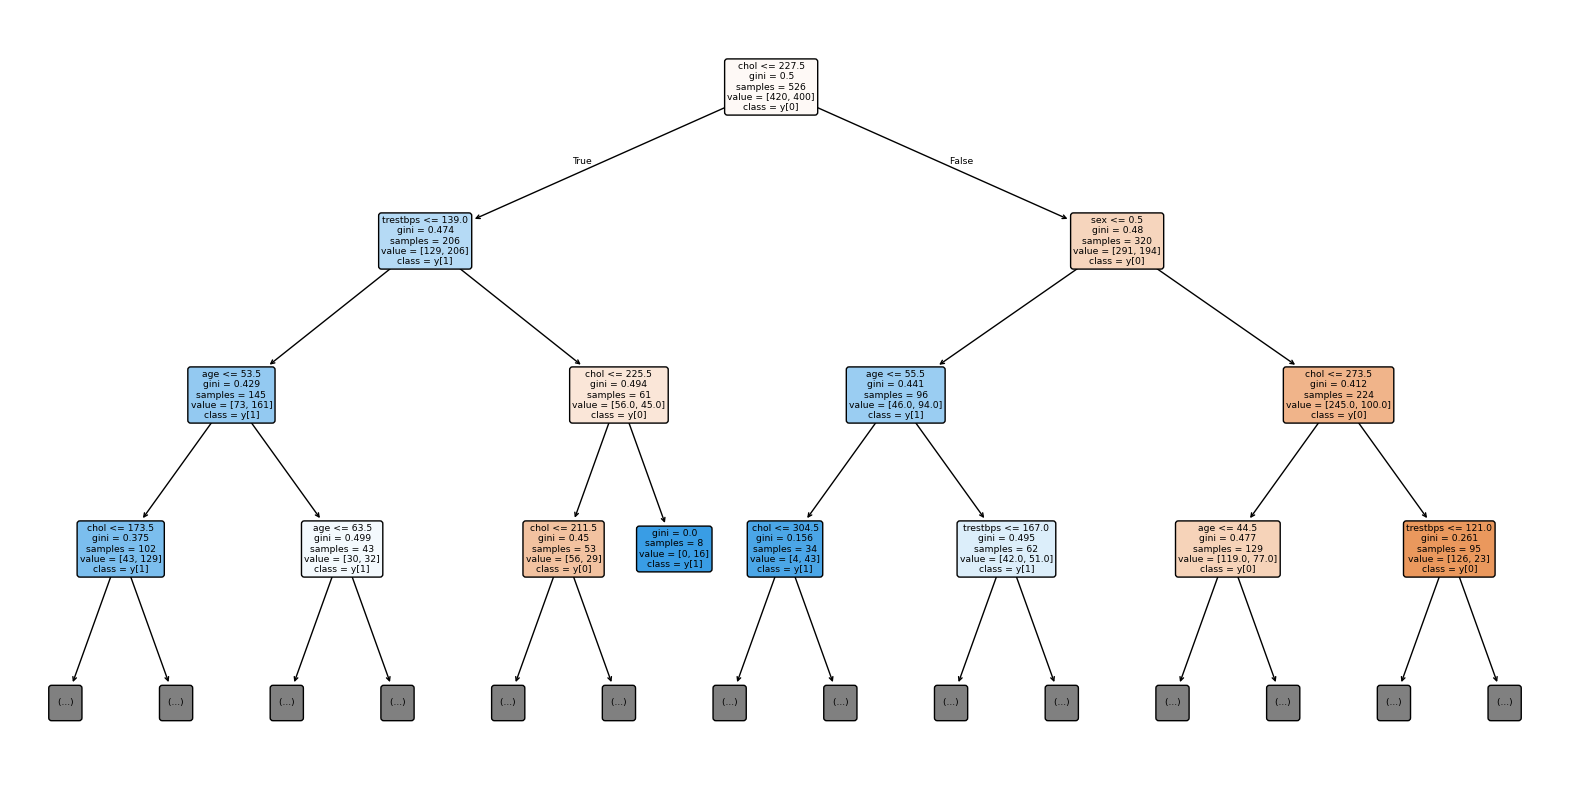

In [39]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


tree = best_rf.estimators_[1]

plt.figure(figsize=(20, 10))
#Ajusto la profundidad a 3 ya que sino es muy dificil de ver
plot_tree(
    tree,
    max_depth=3, 
    feature_names=x_train.columns,
    class_names=True,
    filled=True,
    rounded=True
)
plt.show()


<div style="background-color:green;color:white">

<br>

**Explica:**

* Qué variable aparece primero
    - La variable que aparece primero es chol

* Qué significa una condición tipo *chol <= 240*
    - Clasifica en función de si tiene chol <=, Si lo Tiene, clasifica como true, sino como False

* Por qué **no debemos mostrar este árbol a un médico como modelo final**

    - Porque este modelo no representa la decisión final, sino uno de los árboles de decision de todo el bosque, la decisión se podría considerar teniendo en cuenta todo el bosque no solo un árbol

<br>

---

### 5.2 Importancia de variables

En este apartado se va a analizar **qué variables son más importantes para el modelo Random Forest** a la hora de realizar sus predicciones.

Un Random Forest toma decisiones combinando muchos árboles de decisión. En cada árbol, las variables no se usan todas por igual: algunas aparecen con más frecuencia y generan **mejores divisiones** que reducen más la incertidumbre del modelo.
A partir de esta información, el modelo puede estimar la **importancia relativa de cada variable**.

---


#### Pistas para la implementación

* Los modelos `RandomForestClassifier` calculan automáticamente la importancia de las variables tras el entrenamiento.
* Esta información se encuentra en un **atributo del modelo**.
* Para interpretarla correctamente:

  * es conveniente asociar cada valor con el nombre de su variable,
  * y ordenar los resultados para facilitar el análisis.

📌 **Ayuda**
Consulta la documentación de `RandomForestClassifier` para identificar el atributo que almacena la importancia de las variables y su significado.


In [40]:
for i in range(0,4):
    print(x.columns[i])
    print(best_rf.feature_importances_[i])


age
0.3202124654971716
sex
0.12436655008838851
trestbps
0.21650876564571309
chol
0.3389122187687269


<div style="background-color:green;color:white">

<br>

- ¿Coincide con lo que esperarías médicamente?

    - Si, ya que le da más importancia a caracteristicas que producen esa condición médica

- ¿Qué variable eliminarías si quisieras simplificar aún más?

    - Para simplificar se podrían quitar variables como sexo  que no influyen practicamente
<br>

--

## Parte 6 – Comparación crítica de datasets

Entrena **el mismo modelo** con:

* dataset completo
* dataset de 4 variables


---

In [41]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=100,max_depth=5,min_samples_leaf=3,min_samples_split=10,oob_score=True,random_state=42)

In [42]:
#Primer dataset 4 caracteristicas
x = df_4_features[["age","sex","trestbps","chol"]]
y = df_4_features["target"]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

RFC.fit(x_train,y_train)
y_pred = RFC.predict(x_test)

In [43]:
#Comprobamos overfitting
# Accuracy en TRAIN
train_score = RFC.score(x_train, y_train)
# Accuracy en TEST(en regresión devuelve lo mismo que r2)
test_score = RFC.score(x_test, y_test)
print(train_score,test_score)


0.8182926829268292 0.7268292682926829


In [44]:
#Metricas(acurracy)
print(accuracy_score(y_test,y_pred))

0.7268292682926829


In [48]:
#Modelo todas las variables
x = df_heart[["age","sex","trestbps","chol","fbs",	"restecg",	"thalach",	"exang",	"oldpeak",	"slope",	"ca","thal"]]
y = df_heart["target"]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

RFC.fit(x_train,y_train)
y_pred = RFC.predict(x_test)

In [49]:
#Comprobamos overfitting
# Accuracy en TRAIN
train_score = RFC.score(x_train, y_train)
# Accuracy en TEST(en regresión devuelve lo mismo que r2)
test_score = RFC.score(x_test, y_test)
print(train_score,test_score)


0.9402439024390243 0.848780487804878


In [50]:
#Metricas(acurracy)
print(accuracy_score(y_test,y_pred))

0.848780487804878


<div style="background-color:green;color:white">

<br>

Completa una tabla como esta:

| Dataset    | Accuracy | Interpretabilidad | Riesgo de overfitting |
| heart      | 0.84     | Compleja          | Leve(ya que hay diferencia entre test y train)
| 4-features | 0.72     | Facil             | Leve(ya que hay diferencia entre test y train)|
| -------    | -------- | ----------------- | --------------------- |

<br>



<div style="background-color:green;color:white">

<br>

¿Qué modelo recomendarías *en un hospital pequeño* y por qué?

    - Recomendaria el modelo creado a partir de las 4 variables ya que tendría mayor interpretabilidad clínica y generaliza mejor
<br>

---

## Parte 7 – Reflexión final

Responde brevemente (5–6 líneas cada una):

<div style="background-color:green;color:white">

<br>

1. ¿Por qué Random Forest es una buena elección aquí?

    -  Es una buena elección ya que no son relaciones lineales y están basadas en reglas.
    Además al combinar múltiples árboles, reduces el riesgo de overfitting haciendo que generalize mejor

2. ¿Cuándo **no** usarías Random Forest?

    - No usaria Random Forest en casos en los que queramos conseguir una predicción numerica y que no esté basada en reglas. O cuando sean reglas muy sencillas ya que usariamos árboles de decisión, no bosque

3. ¿Qué mejorarías si tuvieras más datos?

    - Con más datos intentaría mejorar la generalización que hace a la hora de detecctar a los posibles enfermos
<br>
